# FreeTrace tutorial

# Requirements
FreeTrace requires Linux platform to infer the molecular trajectories from microscopy video.</br>
- Linux (python3.10&uarr;) with GPU (Cuda).</br>
- Cuda installation: [Nvidia Cuda installation](https://developer.nvidia.com/cuda-toolkit)</br>
You can run FreeTrace without GPU, however it infers the trajectory under standard Brownian motion rather than fracitonal Brownian motion.</br>
In the case of high molecular density in heterogenous medium, we recommend you to run FreeTrace with GPU equipped machine.

# FreeTrace installation
After donwload FreeTrace via pip, the import of FreeTrace.installation will download additional DNN models, packages and compile the C codes which are mandatory to run the FreeTrace. If you don't want to upgrade your python packages to the latest version, please install it manually. The required packaged is enumerated in the requirements.txt.</br>
FreeTrace utilizes tensorflow 2.14/2.17 to run it with sourcecode. Without GPU, FreeTrace doesn't need Tensorflow and infer the trajectories under standard Brownian motion. Once the installation is succesfully finished, you don't need to re-import the FreeTrace.installation for each inference.

In [ ]:
!pip3 install FreeTrace
import FreeTrace.installation

# FreeTrace algorithm

FreeTrace is consist of two major algorithms.
- Localization of particles from video.</br>
- Reconnection of particles over time.</br>
The units of FreeTrace output are pixel (coordinate) and frame (time). To analyse the result with your microscopy setting, you need to convert the data into micrometer/nanometer and miliseconds.</br>

The detailed algorithm of FreeTrace will be available soon.

# 1. Parameter settings
Below is pre-defined parameters to run FreeTrace.</br>

In [1]:
from FreeTrace import Tracking, Localization

video_name = 'inputs/sample0.tiff'  # input video path.
output_dir = 'outputs'  # output path.
verbose = 1  # print ETA of process if verbose=1, 0 otherwise.

window_size = 7  # Length (pixel) of sliding window to localize molecules from video
threshold = 1.0  # Threshold factor to determine the existence of molecule inside sliding windows, base thresholds are calculated with SNR of images.
realtime_localization = True  # Real time visulaization of localization if True, False otherwise.
gpu_for_localization = True  # GPU acceleration of localization if True, False otherwise.
save_localization_video = False  # Save the visualized localization in tiff format.

time_forecast = 5  # Number of frames for the inference of trajectories at each step, between 1 and 10. Higher number will slow down the speed.
cutoff = 2  # Minimum length of trajectory for the output.
jump_threshold = None  # Maximum jump length of molecules for each frame. If None, FreeTrace estimate it automatically with GMM.
realtime_tracking = True  # Real time visulaization of tracking if True, False otherwise.
gpu_for_tracking = True  # Tracking under fBm if True. otherwise, FreeTrace infers the trajectories with standard Brownian motion.
save_tracking_video = False  # Save the visualized trajectories in tiff format.

# 2. Localization

- Run the localization of molecules from video with pre-difined parameters above.</br>
- Tracking.run_process() returns True if it finishes successfully.

In [ ]:
loc = Localization.run_process(input_video_path=video_name,
                               output_path=output_dir,
                               window_size=window_size,
                               threshold=threshold,
                               gpu_on=gpu_for_localization,
                               save_video=save_localization_video, 
                               realtime_visualization=realtime_localization,
                               verbose=verbose)

# 3. Trajectory inference

- Run the tracking of localized molecules from video and localization results, with pre-defined parameters above.</br>
- Tracking.run_process() returns True if it finishes successfully.

In [ ]:
track = Tracking.run_process(input_video_path=video_name,
                             output_path=output_dir,
                             time_forecast=time_forecast,
                             cutoff=cutoff,
                             jump_threshold=jump_threshold,
                             gpu_on=gpu_for_tracking,
                             save_video=save_tracking_video,
                             realtime_visualization=realtime_tracking,
                             verbose=verbose)

Once the localization and tracking of FreeTrace finish succesfully, you can find the molecular trajectory file in your output directory with the name <b>video_traces.csv</b>.</br></br>
If your trajectory is heterogeneous, you need an additional external software to segment the trajectory.</br>
Below is the simple analysis steps of trajectory data, we assumed that your trajectory is homogeneous or already segmented with your preferred software.</br>

# 4. Load trajectory data

In [26]:
from FreeTrace.module.DataLoad import read_csv, read_multiple_csv
trajectory_data = read_csv(file='outputs/sample0_traces.csv')
#trajectory_data = read_multiple_csv('outputs')
trajectory_data

,traj_idx,frame,x,y,z,state,K,alpha
0,0,26,76.694749,54.818897,NaN,NaN,NaN,NaN
1,0,28,75.835419,54.806431,NaN,NaN,NaN,NaN
2,0,29,73.202596,52.991906,NaN,NaN,NaN,NaN
3,1,53,50.813867,88.933434,NaN,NaN,NaN,NaN
4,1,54,51.862681,88.090885,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1798,174,42,14.876284,23.241478,NaN,NaN,NaN,NaN
1799,174,43,14.985898,23.047134,NaN,NaN,NaN,NaN
1800,174,44,14.766510,22.907010,NaN,NaN,NaN,NaN
1801,175,21,11.303980,46.811428,NaN,NaN,NaN,NaN


# 5. Simple analysis of trajectory

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from FreeTrace.module.preprocessing import simple_preprocessing

"""
Option settings for data analysis.
"""
PIXELMICRONS = 0.16
FRAMERATE = 0.01
CUTOFF = 2  # miminum length of trajectory to conisder for the analysis.
number_of_bins = 50
figure_resolution_in_dpi = 200
figure_font_size = 20


"""
preprocessing generates 4 data.
@params: data folder path, pixel microns, frame rate, cutoff
@output: Analysis_data1(pd.DataFrame), Analysis_data2(pd.DataFrame), MSD(pd.DataFrame), TAMSD(pd.DataFrame)

Simple_preprocessing includes below steps.
1. exclude the trajectory where length is shorter than CUTOFF
2. convert from pixel unit to micrometer unit with PIXELMICRONS and FRAMERATE
3. generate 4 DataFrames.
"""
analysis_data1, analysis_data2, msd, tamsd = simple_preprocessing(data=trajectory_data,
                                                                  pixelmicrons=PIXELMICRONS,
                                                                  framerate=FRAMERATE,
                                                                  cutoff=CUTOFF)

print(f'\nanalysis_data1:\n', analysis_data1)
print(f'\nanalysis_data2:\n', analysis_data2)
print(f'\nMSD:\n', msd)
print(f'\nEnsemble-averaged TAMSD:\n', tamsd)

# 6. Plots of analysed trajectory data.</br>
Data is stored as</br>
1. analysis_data1: (DataFrame: contains data of mean_jump_distance, duration, traj_id, color_code)</br>
2. analysis_data2: (DataFrame: contains data of displacments, color_code)</br>
3. msd: (DataFrame: contains msd.) </br>
4. tamsd: (DataFrame: contains ensemble-averaged tamsd.) </br>

Units: </br>
mean jump-disatnce: set of averages of jump distances in um.</br>
duration: duration of trajectory in seconds.</br>
displacement: displacement(time lag=1) of all trajectories in um.</br>

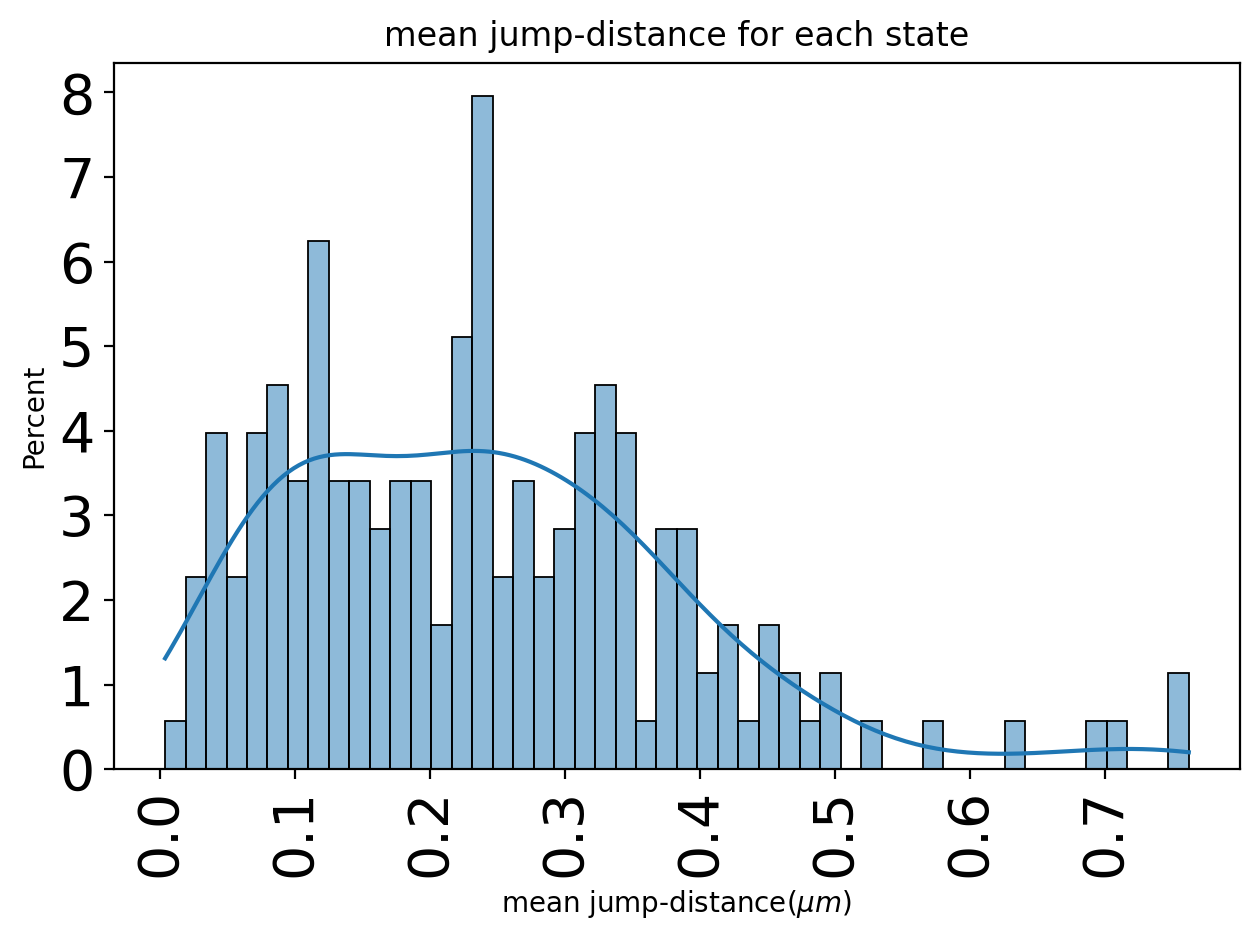

In [20]:
#p1: histogram with kde(kernel density estimation) plot of mean jump distance grouped by state.
plt.figure(f'p1', dpi=figure_resolution_in_dpi)
p1 = sns.histplot(analysis_data1, x=f'mean_jump_d', stat='percent', bins=number_of_bins, kde=True)
p1.set_xlabel(r'mean jump-distance($\mu m$)')
p1.set_title(f'mean jump-distance for each state')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size)
plt.xticks(rotation=90)
plt.tight_layout()

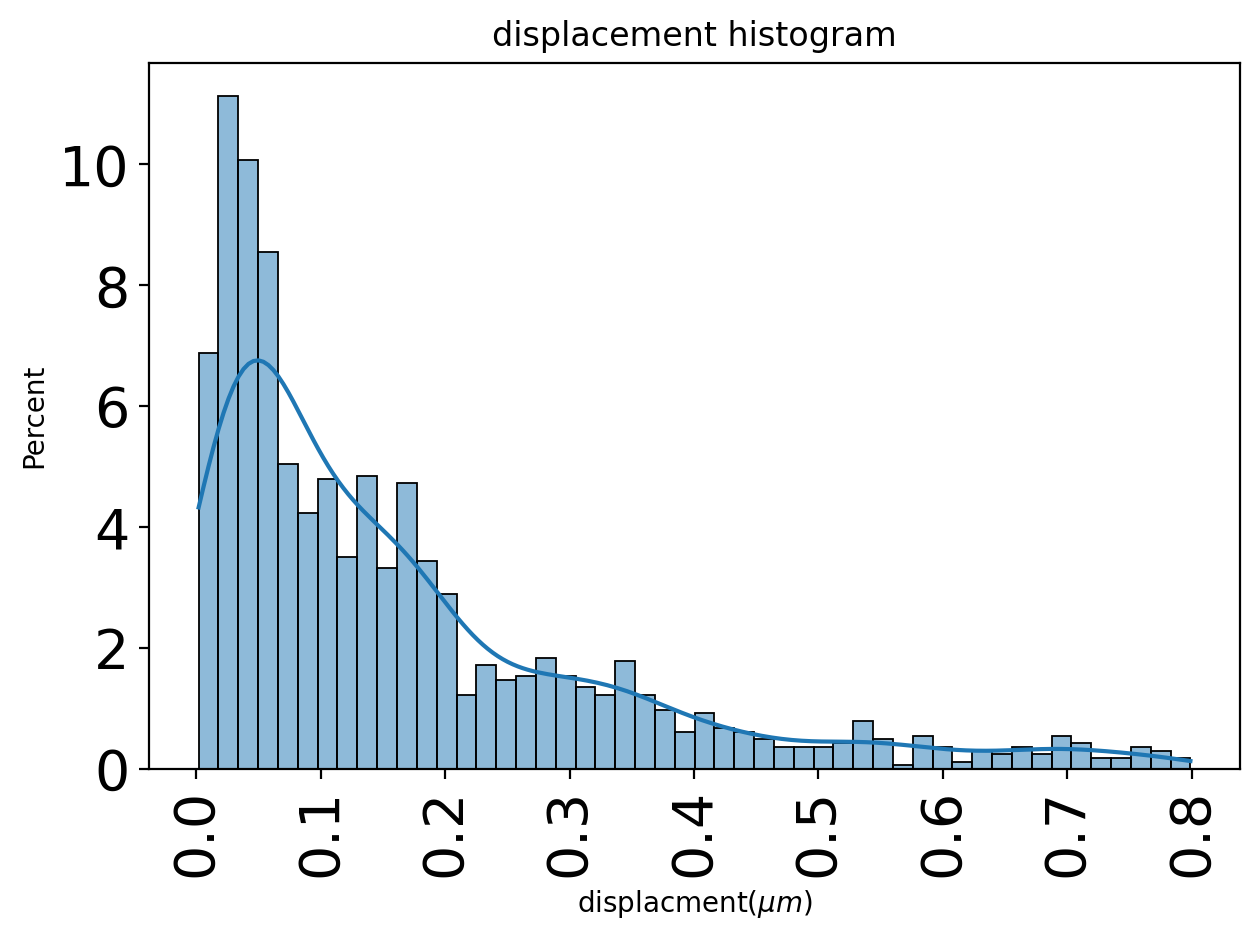

In [21]:
#p2: displacement histogram
plt.figure(f'p2', dpi=figure_resolution_in_dpi)
p2 = sns.histplot(data=analysis_data2, x='displacements', stat='percent', bins=number_of_bins, kde=True)
p2.set_title(f'displacement histogram')
p2.set_xlabel(r'displacment($\mu m$)')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size)
plt.xticks(rotation=90)
plt.tight_layout()

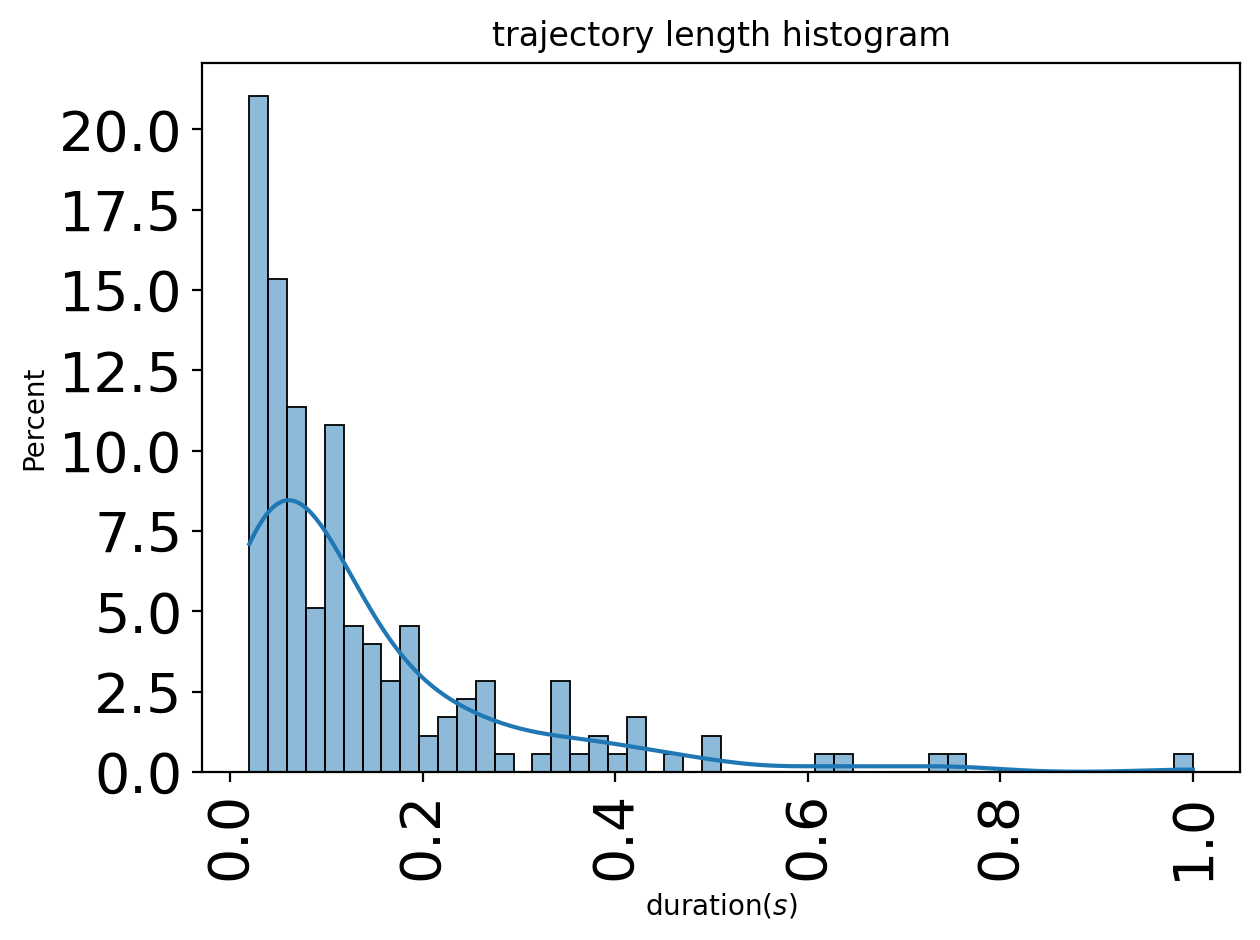

In [22]:
#p3: trajectory length(sec) histogram
plt.figure(f'p3', dpi=figure_resolution_in_dpi)
p3 = sns.histplot(data=analysis_data1, x='duration', stat='percent', bins=number_of_bins, kde=True)
p3.set_title(f'trajectory length histogram')
p3.set_xlabel(r'duration($s$)')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size)
plt.xticks(rotation=90)
plt.tight_layout()

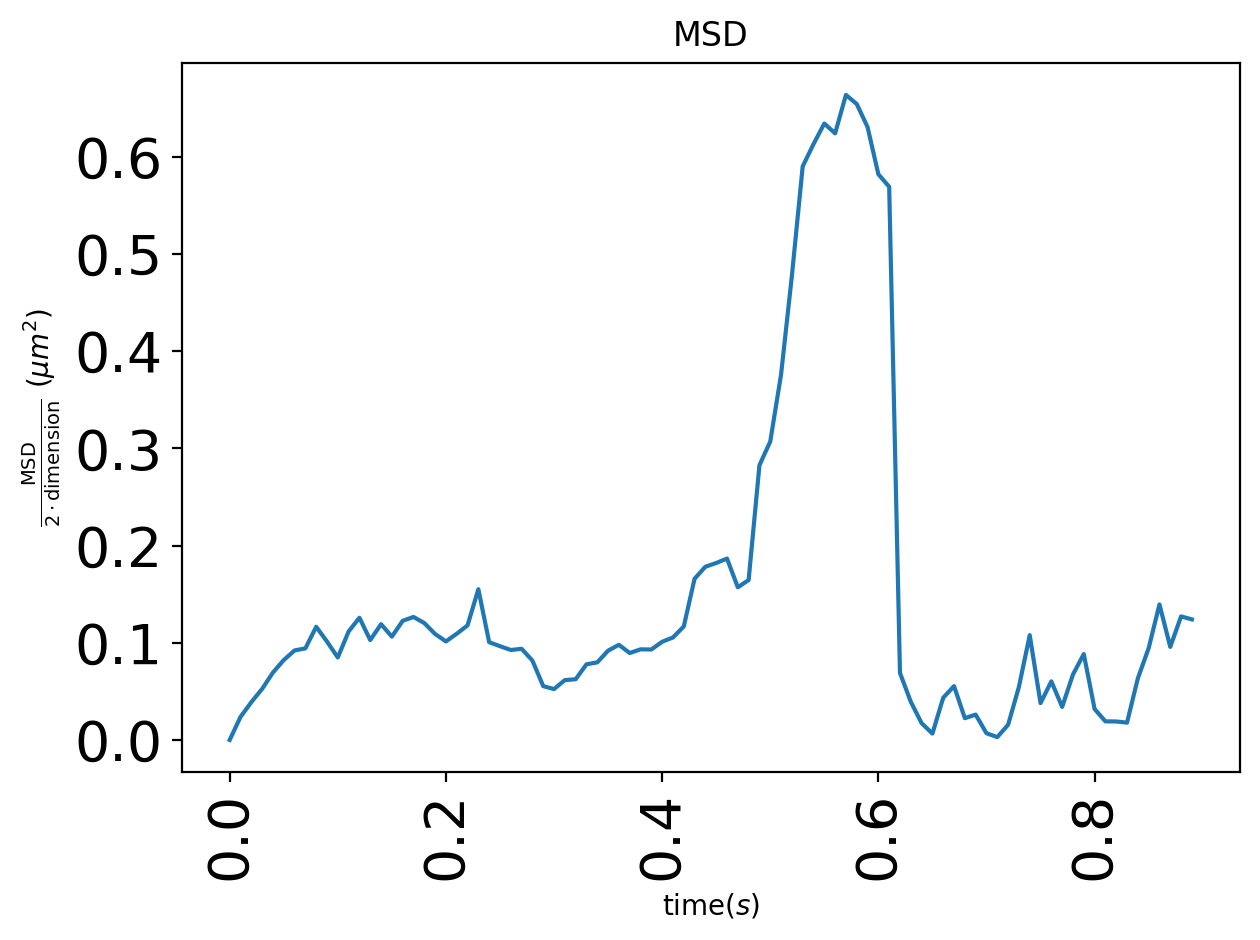

In [23]:
#p4: MSD
plt.figure(f'p4', dpi=figure_resolution_in_dpi)
p4 = sns.lineplot(data=msd, x=msd['time'], y=msd['mean'])
p4.set_title(f'MSD')
p4.set_xlabel(r'time($s$)')
p4.set_ylabel(r'$\frac{\text{MSD}}{\text{2} \cdot \text{dimension}}$ ($\mu m^2$)')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size)
plt.xticks(rotation=90)
plt.tight_layout()

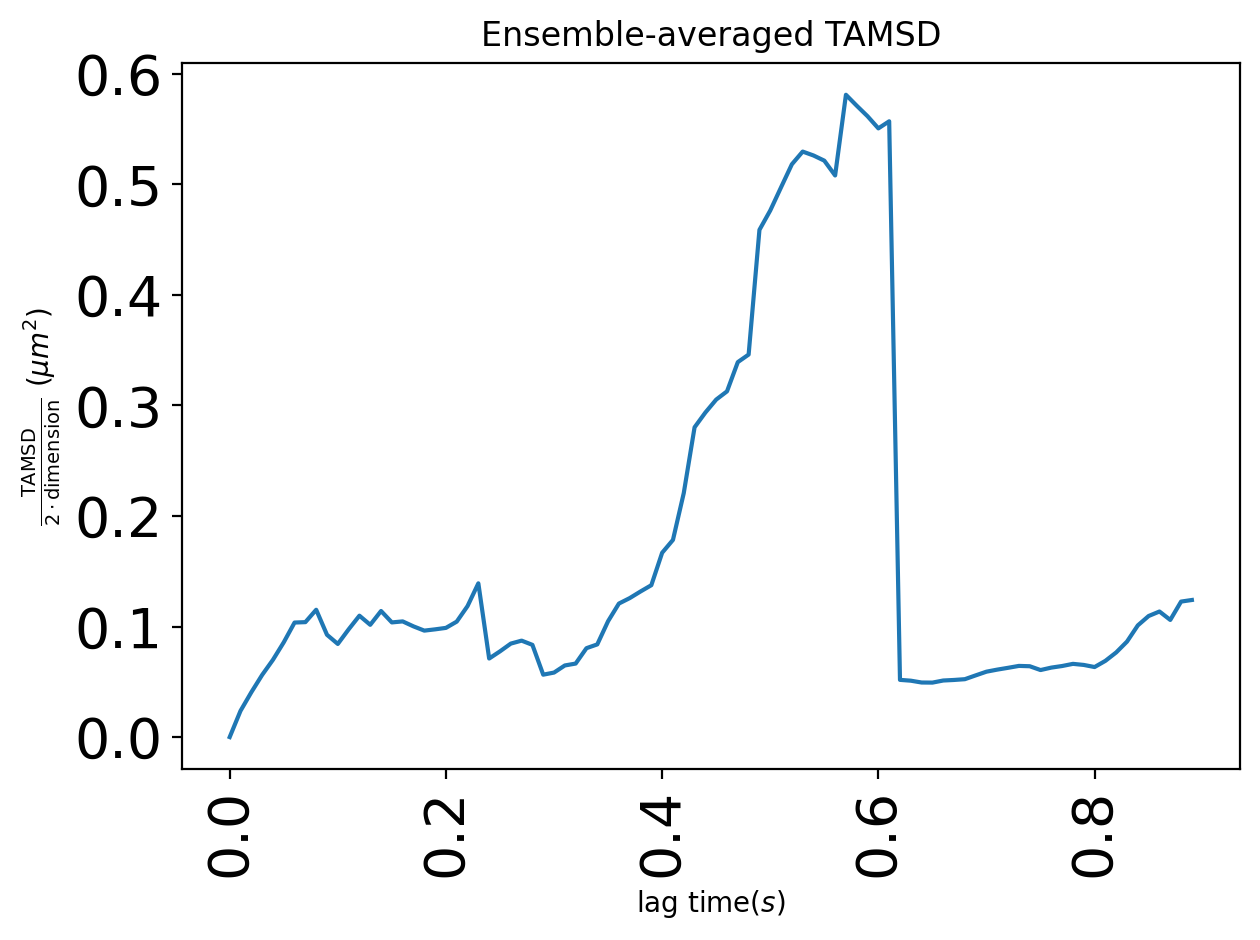

In [24]:
#p5: Ensemble-averaged TAMSD
plt.figure(f'p5', dpi=figure_resolution_in_dpi)
p5 = sns.lineplot(data=tamsd, x=tamsd['time'], y=tamsd['mean'])
p5.set_title(f'Ensemble-averaged TAMSD')
p5.set_xlabel(r'lag time($s$)')
p5.set_ylabel(r'$\frac{\text{TAMSD}}{\text{2} \cdot \text{dimension}}$ ($\mu m^2$)')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()